In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import scipy.integrate as ode
plt.rc("figure",figsize=(16,10))

In [2]:
##all the basics functions##

def fitness_dual(A,mu=1):
    lambda01=mu*(A[1,0]-A[0,1])+A[1,0]-A[1,1]
    lambda10=mu*(A[0,1]-A[1,0])+A[0,1]-A[0,0]
    return lambda01,lambda10

def fitness(A,mu=1):
    """Computation of the fitness of the reducted model.
    A is the matrix of interaction and mu is the ratio I/II
    """
    n=len(A)
    return np.array(mu*(A.T-A)+A.T-np.matrix(np.ones((n,1)))*np.matrix(np.diagonal(A)))
def theta(R0,k,beta=1):
    T=1-1/R0
    I=(R0-1)/(R0+R0*k*(R0-1))
    D=T-I
    return beta*I*D*T/(2*T**2-I*D) 
def thetamu(R0,k,beta=1):
    return theta(R0,k,beta=beta)/(R0-1)*k
def slowdyn(T,z,Lambda=None,D=1):
    n=len(z)
    if type(z) is list:
        z=np.array(z)
    z=np.array([10**(-30) if u<0  else u for u in list(z)])
    z=z/np.sum(z)
    if Lambda is None : Lambda=np.array([[]])
    if type(Lambda) is list : Lambda=np.array(Lambda)
    if np.shape(Lambda)!=(len(z),len(z)):
        print('Attention mauvais lambda. Remplacement par une valeur par défaut')
        Lambda=np.ones((len(z),len(z)))
    Lambda=Lambda-np.diag(np.diag(Lambda))
    Q=np.dot(z.T,np.dot(Lambda,z))
    L=np.dot(Lambda,z)

    return D*np.array(z)*(L-Q)

illustrate for N=20 for a GIVEN network

In [3]:
##generation of the graph##
def network(LL):
    """define the graph for a given fitness LL"""
    if LL is list :
        LL=np.array(LL)
    LL=LL-np.diag(np.diag(LL)) # be sure that the self fitness is zero
    G=nx.DiGraph()
    n=len(LL)
    nodes=['{}'.format(i+1) for i in range(n)]
    G.add_nodes_from(nodes)
    pair=[(i,j) for j in range(n) for i in range(j) 
           if LL[i,j] !=0 or LL[j,i] !=0  ]
    edges=[('{}'.format(x[0]+1),'{}'.format(x[1]+1)) for x in pair]
    G.add_edges_from(edges)
    for (i,j),(a,b) in zip(pair,G.edges):
        G[a][b]['type']='degenerate'
        if LL[i,j]<0 and LL[j,i]<0: G[a][b]['type']='bist'
        elif LL[i,j]>0 and LL[j,i]>0: G[a][b]['type']='coex'
        elif LL[i,j]<0 and not LL[j,i]<0: G[a][b]['type']='excl_'+b
        elif not LL[i,j]<0 and LL[j,i]<0: G[a][b]['type']='excl_'+a
        #print(classe)
    return G
def net_draw(G,**kwargs):
    """plot the graph G
    kwargs as the following entry :
    - nodes : z, the size of the nodes. Default is 100
    -ax= plot on the curent ax. default is None"""
    zz=np.array(kwargs.pop('nodes',[1/G.number_of_nodes()]*G.number_of_nodes()))
    ax=kwargs.pop('ax',None)
    edges_size=kwargs.pop('edges_size',None)
    zcolor=kwargs.pop('zcolor','grey')
    if ax is None : fig,ax=plt.subplots()
    pos=nx.layout.circular_layout(G)
    nx.draw_networkx(G,pos=pos,
            node_size=1500*zz+0.01,node_color=zcolor,alpha=1,
           edgelist=[], ax=ax,font_size=30 )
    edgecoex,edgebist,edgeexclui,edgeexcluj=[],[],[],[]
    edgecoex_size,edgebist_size,edgeexclui_size,edgeexcluj_size=[],[],[],[]
    for i,j in G.edges :
        
        if G[i][j]['type']=='coex':
            edgecoex.append((i,j))
            edgecoex_size.append(20*zz[eval(i)-1]*zz[eval(j)-1])
        elif G[i][j]['type']=='bist':
            edgebist.append((i,j))
            edgebist_size.append(20*zz[eval(i)-1]*zz[eval(j)-1])
        elif G[i][j]['type']=='excl_'+j:
            edgeexclui.append((i,j))
            edgeexclui_size.append(20*zz[eval(i)-1]*zz[eval(j)-1])
        elif G[i][j]['type']=='excl_'+i:
            edgeexcluj.append((j,i))
            edgeexcluj_size.append(20*zz[eval(i)-1]*zz[eval(j)-1])
    if edges_size=='ztype' : print('adaptative edges width')
    elif edges_size==None : 
        edgecoex_size=5
        edgebist_size=5
        edgeexclui_size=[5]*len(edgeexclui)
        edgeexcluj_size=[5]*len(edgeexcluj)
    else: 
        edgecoex_size=edges_size
        edgebist_size=edges_size
        edgeexclui_size=[edges_size]*len(edgeexclui)
        edgeexcluj_size=[edges_size]*len(edgeexcluj)
    nx.draw_networkx_edges(G,pos=pos,
                           edgelist=edgecoex,
                           edge_color='red',
                           width=edgecoex_size,
                           arrows=True,
                           arrowsize=0.001,
                           alpha=1,
                           node_size=1000,
                           #connectionstyle='Arc3, rad=0.1',
                          ax=ax)
    nx.draw_networkx_edges(G,pos=pos,
                           edgelist=edgebist,
                           width=edgebist_size,
                           edge_color='blue',
                           arrows=True,
                           arrowsize=0.001,
                           alpha=1,
                           node_size=1000,
                           #connectionstyle='Arc3, rad=0.1',
                          ax=ax)
   
    for edg,edg_size in zip(edgeexclui+edgeexcluj,edgeexclui_size+edgeexcluj_size):
        nx.draw_networkx_edges(G,pos=pos,
                               width=[edg_size],
                               edgelist=[edg],
                               edge_color='grey',
                               style='dotted',
                               arrowsize=10*edg_size,
                               arrowstyle='-|>',
                               alpha=0.8,
                               node_size=1000,
                               #connectionstyle="angle3,angleA=-45,angleB=45",
                               ax=ax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

In [4]:
##computation of the dynamics##
def traject(T,X0,fit,D=1):
    """kwargs=[A,mu] or kwargs=[Lambda]"""

    if type(X0) is list: X0=np.array(X0)
    if (X0<0).any() : 
        print('negativ entry')
        return None
    if (X0==0).all() : 
        print('no positiv entry')
        return  None
    X0=X0/np.sum(X0)
    def f_eval(t,X):
        Z=slowdyn(t,X,Lambda=fit,D=D)[:-1]
        return np.concatenate((Z,np.array([-sum(Z)])))
    resultat = ode.solve_ivp(fun=f_eval, 
                             t_span=(0, T), 
                             y0=X0,
                             dense_output=True
                             #t_eval=np.arange(0,T,0.1),
                            )
    return resultat
def simu(T=100,mu=None,A=None,fit=None,n=3,z0=None,T_threshold=None,V_threshold=10**-4,**kwargs):
    """Compute the dynamics for a n strain system.
    Input are :
    -T the final time 
    -mu the ratio I/D=1/(k(R0-1))
    -A the array of rescalled interactions.  A is automatiquely renormalised such that the euclidan norm is ||A||=1
    -fit the matrix of fitness (usefull if neither mu nor A is given).
    -n the number of species (usefull is neither mu nor A nor fit is given)
    If mu and A are given, the fitness is computed by the function fitness.
    If mu is given and not A, then A is generated randomly using a uniform distribution between -1 and 1
    If A is given and not mu then mu is generated randomly using a uniform distribution between 0 and 10
    If none of mu, A or fit are  given, then mu=1 and A  is generated by using a uniform distribution between -1 and 1.
    
    Additional arguments are 
    -z0 : the initial data
    -V_threshold : If z_i < threshold, then the strain i is considered to be not here
    -T_threshold: a percentage of T from which we compute the threshold. Default is 100%
    The output are mu, A, fit, the resultat of the dynamics and the number of coexistent species
    """
    if mu is not None and A is  None :
        A=2*np.random.random((n,n))-1
    if  A is not None :
        if A is list:   A=np.array(A) ## Transform A in Array
        A=A/sum(sum(A**2)) ## renormalisation of A
        if mu is None : mu=10*np.random.random(1) ##generation of mu if needed
        n=len(A)
        fit=fitness(A=A,mu=mu)
    if mu is None and A is None and fit is None :
        mu=1
        A=2*np.random.random((n,n))-1
        A=A/sum(sum(A**2))
        fit=fitness(A=A,mu=mu)
    n=len(fit)
    if z0 is not None and len(z0)!=n : 
        print('Mistake in z0, the size len(z0)={}'.format(len(z0)),
                                                          r'$\ned$',
                                                          'n={}'.format(n),
                                                          'a random z0 is taken.') 
        z0=np.random.random(n)
    if z0 is None : z0=np.random.random(n)  ##Generation of the initial data
    ##Computation of the dynamics
    D=kwargs.pop('D',1)
    resultat=traject(T=T,X0=z0,fit=fit,D=D)
    if T_threshold is None : nc=len(resultat.y[:,-1][resultat.y[:,-1]>V_threshold])
    
    else :  
            Tstart=T*T_threshold
            ind_threshold=np.int(np.min(np.arange(0,len(resultat.t),1)[resultat.t>Tstart].tolist()+[T]))
            mean=np.mean(resultat.y[:,ind_threshold:],axis=1)
            nc=len(mean[mean>V_threshold])
    return mu, A,fit,resultat,nc

In [16]:
def plot_dynamics(resultat=None,details=1000,ax=None,isplot=True,**kwargs):
    """Plot the dynamics from simu"""
    if resultat is None :
        mu, A,fit,resultat,nc=simu(**kwargs)
        kwargs['mu']=mu
        kwargs['A']=A
        kwargs['fit']=fit
        kwargs['nc']=nc
    D=kwargs.pop('D',1)
    z0=kwargs.pop('z0',None)        
    mu=kwargs.pop('mu',None)
    n=kwargs.pop('n',3)
    A=kwargs.pop('A',None)
    fit=kwargs.pop('fit',None)
    nc=kwargs.pop('nc',None)
    istitle=kwargs.pop('istitle',True)
    T=kwargs.pop('T',resultat.t[-1])
    V_threshold=kwargs.pop('V_threshold',10**-4)
    T_threshold=kwargs.pop('T_threshold',1)
    n=len(resultat.y)
    if ax is None : 
        fig,ax=plt.subplots() 
        
    y=resultat.sol(np.linspace(0,T,details))
    for i in range(np.shape(resultat.y)[0]):
        ax.plot(np.linspace(0,T,details),y[i],**kwargs,visible=isplot)
    if istitle:
        titre='N={} strains and '.format(n) 
        coexist=(nc>1)*'{} strains coexist'.format(nc)+(nc==1)*'1 strain survives '
        mean= '\n(mean> {:0.0e} on the last {:0.0f}% of time) '.format(V_threshold, (1-T_threshold)*100)
        ax.set_title(titre+coexist+mean) 
    ax.set_xlabel('Time '+r'$\tau$',fontsize=30)
    ax.set_ylabel('Strain frequency $z_i$', fontsize=30)
    ax.yaxis.set_ticks_position('left')
    
    RETURN={}
    RETURN['mu']=mu
    RETURN['A']= A
    RETURN['fit']=fit
    RETURN['res']=resultat
    RETURN['nc']=nc
    return RETURN

In [20]:
##add the graph of the system next to the dynamics##

def picture(Tm=100,ax1=None,ax2=None,num=None,**kwargs):
    if ax1 is None and ax2 is None : fig,(ax1,ax2)=plt.subplots(num=num,nrows=1, ncols=2)
    elif ax1 is None and ax2 is not None : fig,ax1=plt.subplots()
    elif ax2 is None and ax1 is not None : fig,ax2=plt.subplots()
    
    Galpha=kwargs.pop('Galpha',1.)
    dic=plot_dynamics(ax=ax2,T=Tm,**kwargs)
    N=len(dic['fit'])
    zco=[cu.get_color() for cu in ax2.get_children()[0:N]]
    Fit,res=dic['fit'],dic['res']
    G=network(Fit)
    pos=nx.drawing.circular_layout(G)
    #times,=ax2.plot([0,0],[0,1],'--k')
    ax2.set_yticks([0,0.25,0.5,0.75,1])
    ax2.set_yticklabels(['']*5)
    #ax2.set_xticks([k*Tm/5 for k in range(5)])
    #ax2.set_xticklabels(['']*5)
    z=res.sol([0])
    dyna=sum([pos[x]*zt for x,zt in zip(pos,z[:,0])])
    net_draw(G,nodes=z[:,0],ax=ax1,zcolor=zco,Galpha=Galpha)
    actual,=ax1.plot(*dyna,'.k')
    trajectory,=ax1.plot([],[],'-k',alpha=0.3)
    #title=ax1.set_title(r'$\tau=${:0.0f}'.format(0))
    #ax1.text(-0.05,1.05,'A', fontsize='xx-large',transform=ax1.transAxes)
    #ax2.text(-0.05,1.05,'B', fontsize='xx-large',transform=ax2.transAxes)
    ax2.grid(True)
    dico=dict()
    #dico['times']=times
    dico['axes']=ax1,ax2
    dico['colors']=zco
    dico['results']=dic
    dico['Galpha']=Galpha
    return dico


In [106]:
##final plot. generation of the dynamics on  on the graph##

def dyna_mu(MMU,MatrixA,AX_plot,ZZ=None,**kwargs):
    """each columns for on values of mu. Each line for one matrix."""
    n=len(MMU)
    TTf=kwargs.pop('Tm',[[200]*3]*2)    
    if ZZ is None:
        ZZ=[np.ones(len(MatrixA[k])) for k in range(len(MatrixA))]
    for A,AX,z0,TT in zip(MatrixA,AX_plot,ZZ,TTf):
        AXG=[AX[k] for k in range(2*n) if k%2==0]#axis for the graph
        AXD=[AX[k] for k in range(2*n) if k%2==1]#axis for the dynamics
        for mu,ax1,ax2,Tfinal in zip(MMU,AXG,AXD,TT):
            fit=fitness(A,mu)
            dico=picture(T_threshold=0.9,fit=fit,Tm=Tfinal,ax1=ax1,ax2=ax2,z0=z0,**kwargs)
            ax1,ax2=dico['axes']
            zco=dico['colors']
            dic=dico['results']
            Fit=dic['fit']
            res=dic['res']
            Tm=res.t[-1]
            step=0.1
            TT=np.arange(0,Tm+step,step)
            z=res.sol(TT)
            G=network(Fit)
            pos=nx.drawing.circular_layout(G)
            def frame(k) : 
                dyna_hist_XX,dyna_hist_YY=[],[]
                for tk in range(k+1):
                    dyna=sum([pos[x]*zt for x,zt in zip(pos,z[:,tk])])
                    dyna_hist_XX+=[dyna[0]]
                    dyna_hist_YY+=[dyna[1]]

                ax1.clear()
                #ax1.text(-0.05,1.05,'A', fontsize='xx-large',transform=ax1.transAxes)

                #print(dyna_hist_XX)
                #net_draw(G,nodes=z[:,tk],ax=ax1,zcolor=zco,Galpha=dico['Galpha'])##si on veut une variation de taille des nodes
                net_draw(G,ax=ax1,nodes=[1]*len(z[:,0]),zcolor=zco,Galpha=dico['Galpha'])##sinon
                ax1.plot(*dyna,'.k')
                ax1.plot(dyna_hist_XX,dyna_hist_YY,'-k',color='black',lw=3,alpha=0.8)
                ax1.plot(dyna_hist_XX[0],dyna_hist_YY[0],'+',color='black',ms=20,alpha=1)
                ax1.plot(dyna_hist_XX[-1],dyna_hist_YY[-1],'.',color='black',ms=15,alpha=1)
                ax1.set_facecolor('white')
                ax2.set_facecolor('white')
                return ax1,ax2
            frame(len(TT)-1)
            
    fig.set_facecolor('white')
    
    return fig

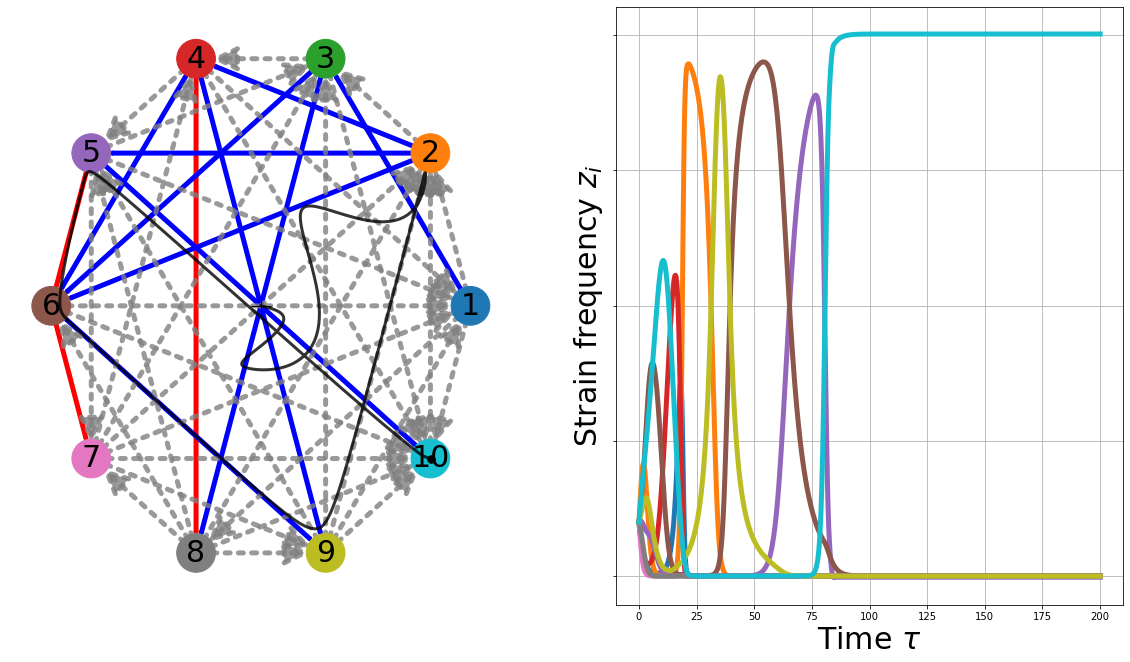

In [111]:
##example with one matrix and one value of mu
n=10
A=2*np.random.random((n,n))-1
fig,AXX=plt.subplots(figsize=(20,11),ncols=2,nrows=1)
MMU=[1]
dyna_mu(MMU,[A],[AXX],lw=5,istitle=False,D=1);    

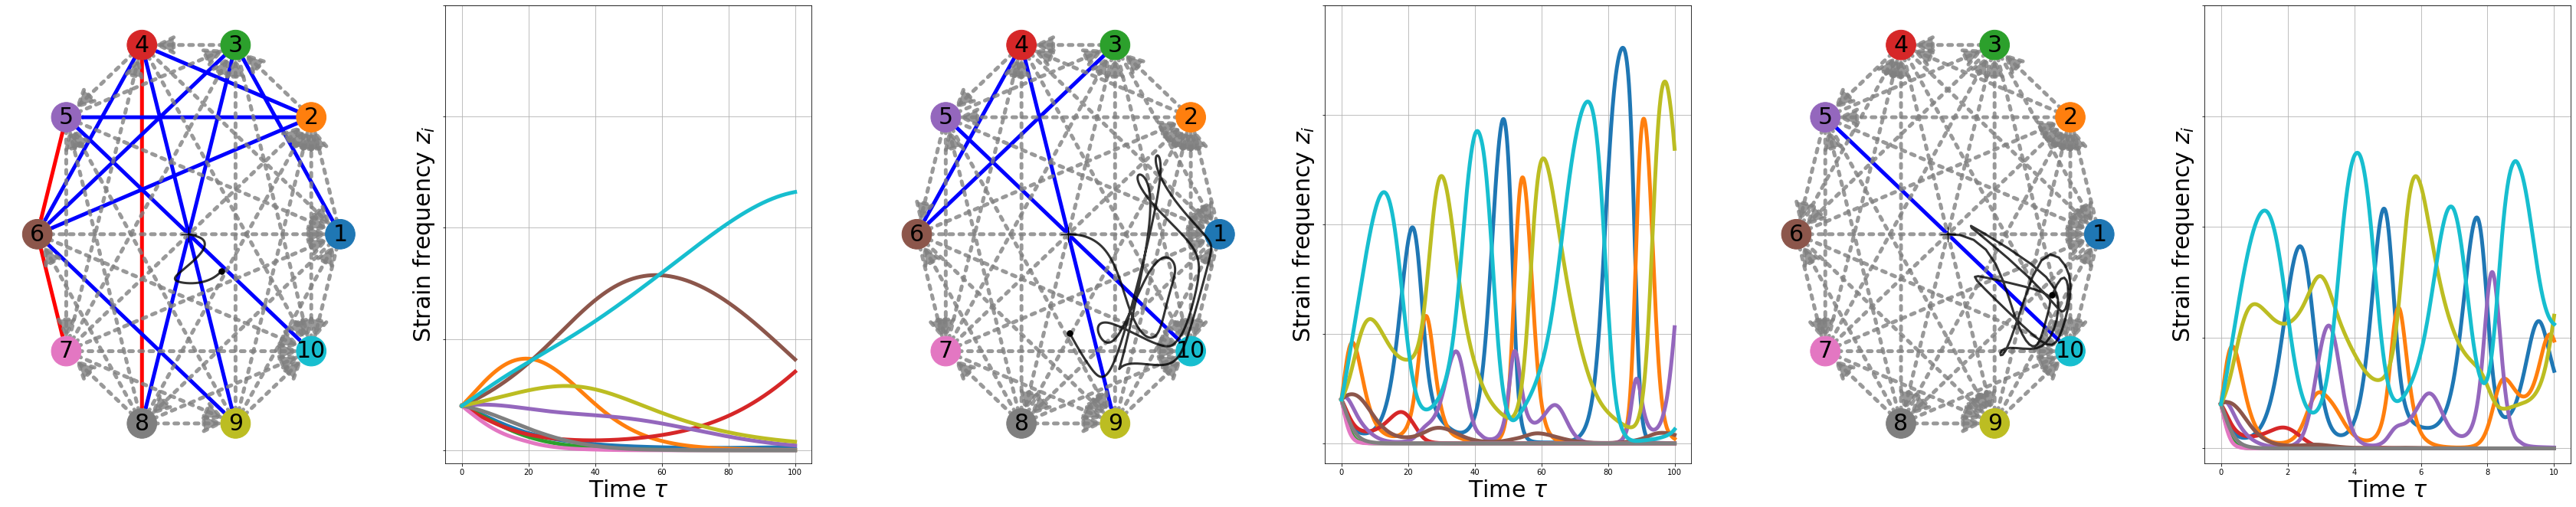

In [112]:
##example with one matrix and 3 values of mu
n=10
#A=2*np.random.random((n,n))-1
fig,AXX=plt.subplots(figsize=(60,11),ncols=6,nrows=1)
MMU=[1,10,100]
dyna_mu(MMU,[A],[AXX],lw=5,istitle=False,Tm=[[100,100,10]],D=0.1);    

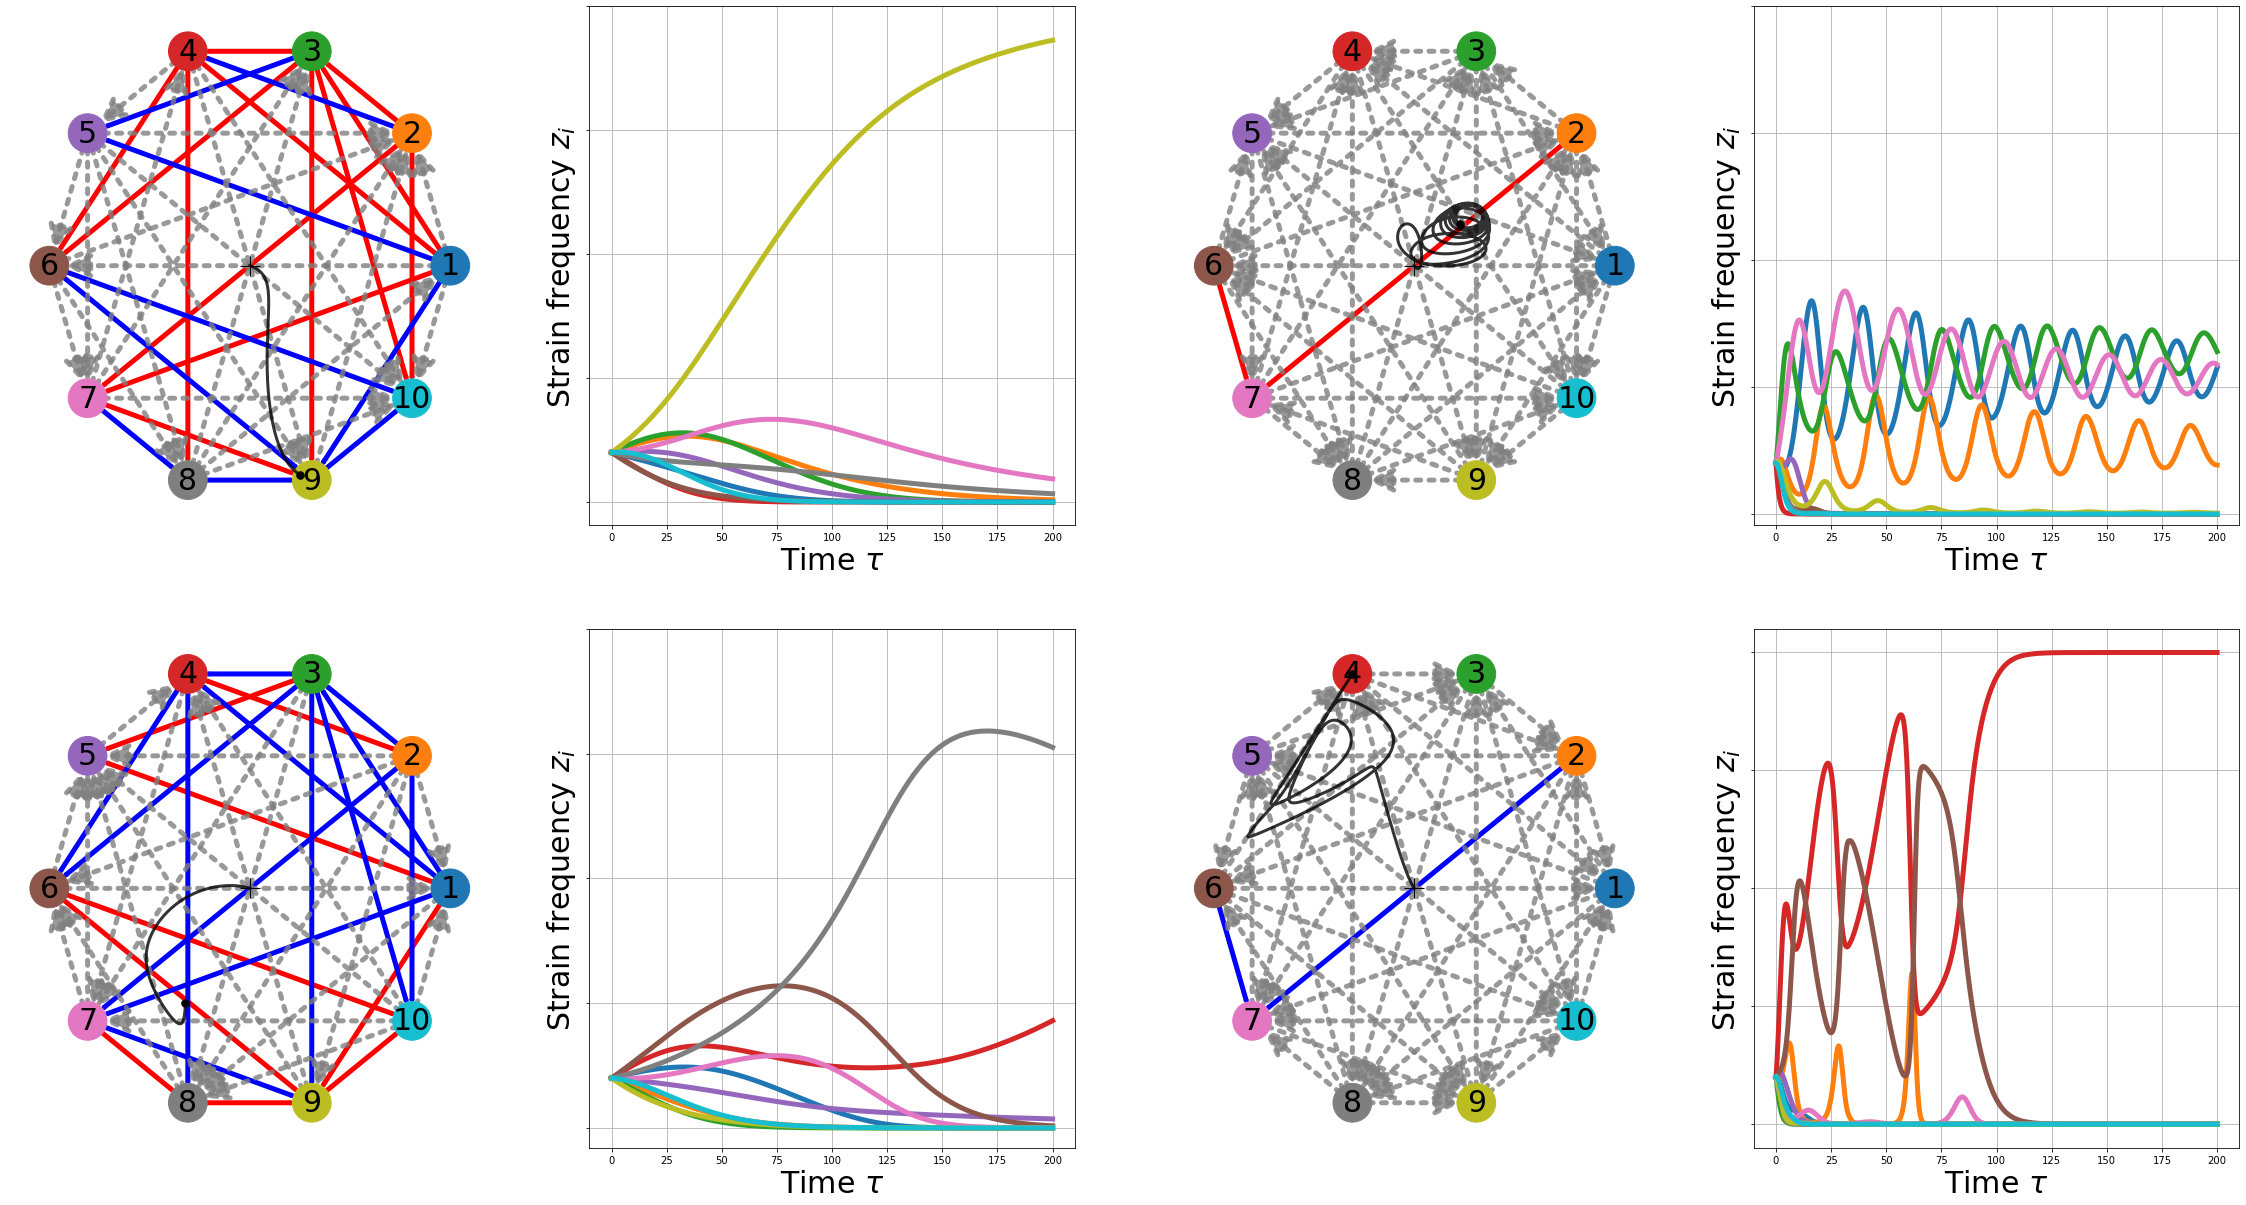

In [114]:
#One example with 2 matrix and 2 values of mu#
n=10
A=2*np.random.random((n,n))-1
fig,AXX=plt.subplots(figsize=(40,21),ncols=4,nrows=2)
dyna_mu(MMU=[0,10],MatrixA=[A,-A],AX_plot=AXX,lw=5,istitle=False,D=0.11);   